# Plot LST/NDVI

## Introduction

After computing the mean, median, minimum, maximum, and standard deviation of LST/NDVI in each HOLC division and summarizing those values by HOLC grade and borough, we want to plot the results. 

There are four types of aggregated data:

1. In `summary_stats_agg`, there is one CSV file for LST and one CSV file for NDVI. In each file, every row contains the average median, median, min, etc. value LST/NDVI grouped by HOLC grade for a single Landsat scene. See Section 3A of the Jupyter notebook `4_compute_summary_stats.ipynb` for details. 
2. In `summary_stats_temporal` there are files named "m2_ext_lst_yr**X**_ pfilt**Y**.csv". These are obtained using Method 2 outlined in 3B of the Jupyter notebook `4_compute_summary_stats.ipynb`.
3. In `summary_stats_temporal` there are files named "m3_ext_lst_yr**X**_ pfilt**Y**.csv". These are obtained using Method 3 outlined in 3C of the Jupyter notebook `4_compute_summary_stats.ipynb`.
4. In `summary_stats_temporal` there are files named "m4_ext_lst_yr**X**_ pfilt**Y**.csv". These are obtained using Method 3 outlined in 3D of the Jupyter notebook `4_compute_summary_stats.ipynb`.

In this notebook, we plot results from all files. 

- Section 1 uses the aggregated statiistics from `summary_stats_agg`
- Section 2 uses data from Method 2 contained in `summary_stats_temporal`.

## Data

Data is imported from the `02-data/summary_stats_agg/` and `02-data/summary_stats_agg-temporal/` folders. Figures are exported to the `03-figs/` folder of the parent directory.

In [161]:
import os
DIR_PARENT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DIR_SCRIPTS = DIR_PARENT + "/01-scripts"

"""Push directory to helper scripts from"""
import sys
sys.path.append(DIR_SCRIPTS)

import helpers

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd


import rioxarray as rxr

DIR_PARENT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DIR_DATA = DIR_PARENT + "/02-data"
DIR_STATS_AGG = DIR_DATA + "/summary_stats_agg"
DIR_STATS_T = DIR_DATA + "/summary_stats_temporal"

DIR_BOUNDARIES = DIR_DATA + "/boundaries"
DIR_BOUNDARIES_HOLC = DIR_BOUNDARIES + "/holc_nyc"

DIR_NDVI_CLIPPED_NYC = DIR_PARENT + "/02-data/ndvi_clipped_nyc"
DIR_LST_CLIPPED_NYC = DIR_PARENT + "/02-data/lst_clipped_nyc"

DIR_FIGS = DIR_PARENT + "/03-figs"

loc_years = ["NYBrooklyn1938","NYBronx1938","NYManhattan1937",
             "NYStatenIsland1940","NYQueens1938"]
lbls_boros = ["Brooklyn","Bronx","Manhattan","StatenIsland","Queens"]
lbls_plot = ["LST", "NDVI"]
lbls_y = ["LST (Kelvin)", "NDVI"]
lbls_yr = ["1984-1993", "1994-2002", "2003-2012", "2013-2022"]
prefix_fname = ["lst", "ndvi"]

plt.rcParams["figure.figsize"] = (7.5,6)


# START FUNCTION DEFINITIONS
def convertKtoF(tempK):
    return (tempK-273.15)*9/5+32 

def parse_date_source_file_col(df):
    return pd.to_datetime(df["source_file"].apply(lambda x: x.split("_")[6]))

def datetime_year(y): 
    return pd.to_datetime("1Jan"+str(y))

## 1. Plot Aggregated Statistics Obtained by Method 1.

Import data in the first cell to be used in the rest of Section 1. 

In [2]:
## USER INPUTS ################################################################
pixelfrac_filter = 0.0 # OPTIONS: 0.0, 0.8, 0.9
obs_choice = 0 # OPTIONS: 1=LST, 2=NDVI
## END USER INPUTS ############################################################

df_stats = pd.read_csv(DIR_STATS_AGG + "/ext_"+prefix_fname[obs_choice]+\
                        "_filt"+str(pixelfrac_filter)+\
                        "_mean_stats_combined.csv")

# Drop the row that contains the HOLC grade E. This comes from the Bronx 
# boundary file. 
df_stats = df_stats[df_stats["holc_grade"]!="E"]

# Add a datetime column to the data
df_stats["datetime"] = parse_date_source_file_col(df_stats)

### A. Box-and-whisker plot for NYC <a id=agg-box-whisker></a>

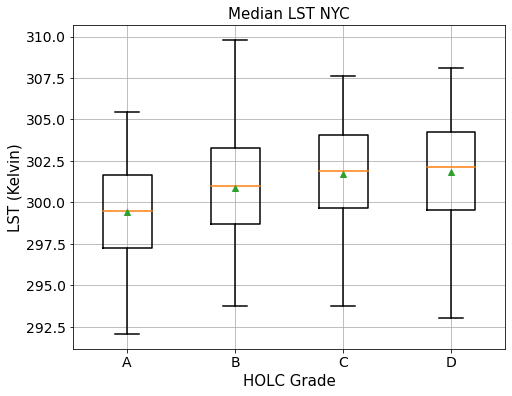

In [76]:
## USER INPUTS ###############################################################
font_size = 15
column_choice = "median" # OPTIONS: median, mean, min, max, std
## END USER INPUTS ###########################################################

plt.rcParams["figure.figsize"] = (7.5,6)
ax = df_stats[df_stats["loc_year"]=="NYC"].boxplot(
                column=[column_choice], 
                by=["holc_grade"],
                grid=True,
                showmeans=True,
                showfliers=False,
                color=dict(boxes='r', whiskers='r', medians='r', 
                           caps='r'),
                boxprops=dict(linestyle='-', linewidth=1.5),
                flierprops=dict(linestyle='-', linewidth=1.5),
                medianprops=dict(linestyle='-', linewidth=1.5),
                whiskerprops=dict(linestyle='-', linewidth=1.5),
                capprops=dict(linestyle='-', linewidth=1.5),
                fontsize=font_size-1)

ax.set_xlabel("HOLC Grade", fontsize=font_size)
ax.set_ylabel(lbls_y[obs_choice], fontsize=font_size)
fig = ax.get_figure()
fig.suptitle("") # Remove default Pandas title
plt.title("Median "+lbls_plot[obs_choice]+" NYC", fontsize=font_size)
plt.savefig(DIR_FIGS + "/boxplot_nyc_"+column_choice+"_"+\
            prefix_fname[obs_choice]+"_filt"+str(pixelfrac_filter)+".png",
            bbox_inches="tight")

### B. Box-and-whisker plot by borough <a id=agg-box-whisker-boro></a>

Text(0.5, 1.0, 'Median LST Queens')

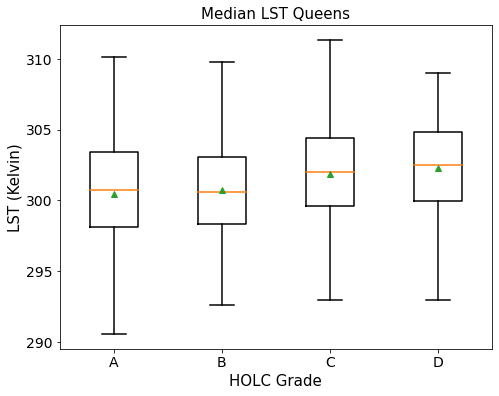

In [38]:
## USER INPUTS #################################################################
loc_year_choice = 4 # OPTIONS: 0 through 4
## END USER INPUTS #############################################################

column_choice = "median" # OPTIONS: median, mean, min, max, std
plt.rcParams["figure.figsize"] = (7.5,6)
font_size = 15
ax = df_stats[df_stats["loc_year"]==loc_years[loc_year_choice]].boxplot(
                column=[column_choice], 
                by=["holc_grade"],
                grid=False,
                showmeans=True,
                showfliers=False,
                color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
                boxprops=dict(linestyle='-', linewidth=1.5),
                flierprops=dict(linestyle='-', linewidth=1.5),
                medianprops=dict(linestyle='-', linewidth=1.5),
                whiskerprops=dict(linestyle='-', linewidth=1.5),
                capprops=dict(linestyle='-', linewidth=1.5),
                fontsize=font_size-1)

ax.set_xlabel("HOLC Grade", fontsize=font_size)
ax.set_ylabel(lbls_y[obs_choice], fontsize=font_size)
fig = ax.get_figure()
fig.suptitle("") # Remove default Pandas title
plt.title("Median " + lbls_plot[obs_choice]+ " " + lbls_boros[loc_year_choice],
          fontsize=font_size)
# plt.savefig(DIR_FIGS + "/boxplot_"+lbls_boros[loc_year_choice]+"_"+
            # column_choice+"_"+prefix_fname[obs_choice]+".png",bbox_inches = "tight")

### C. Observables vs. Time <a id="agg-time"></a>

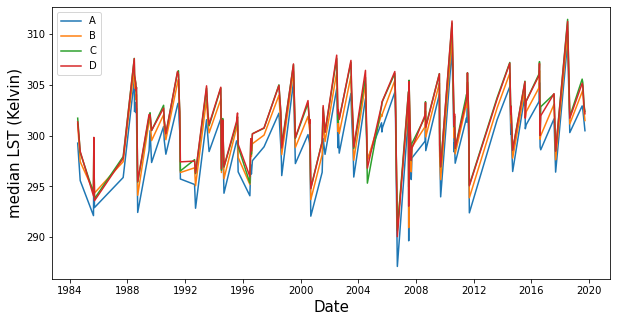

In [44]:
## USER INPUTS ###############################################################
font_size = 15
column_choice = "median" # OPTIONS: median, mean, min, max, std
## END USER INPUTS ###########################################################

df_stats_sorted = df_stats.sort_values(by="datetime")

plt.rcParams["figure.figsize"] = (10,5)

xvals_nyc =  df_stats_sorted[(
    df_stats_sorted["holc_grade"]=="A") & \
    (df_stats_sorted["loc_year"]=="NYC")]["datetime"].values

plt.plot(xvals_nyc, df_stats_sorted[(
    df_stats_sorted["holc_grade"]=="A") & \
    (df_stats_sorted["loc_year"]=="NYC")][column_choice], label="A")
plt.plot(xvals_nyc, df_stats_sorted[(
    df_stats_sorted["holc_grade"]=="B") & \
    (df_stats_sorted["loc_year"]=="NYC")][column_choice], label="B")
plt.plot(xvals_nyc, df_stats_sorted[(
    df_stats_sorted["holc_grade"]=="C") & \
    (df_stats_sorted["loc_year"]=="NYC")][column_choice], label="C")
plt.plot(xvals_nyc, df_stats_sorted[(
    df_stats_sorted["holc_grade"]=="D") & \
    (df_stats_sorted["loc_year"]=="NYC")][column_choice], label="D")

plt.legend(loc='upper left');

plt.xlabel("Date", fontsize = font_size)
plt.ylabel(column_choice + " "+ lbls_y[obs_choice], fontsize=font_size)

plt.savefig(DIR_FIGS + "/"+column_choice+"-"+prefix_fname[obs_choice]+\
            "-vs-time"+"_filt"+str(pixelfrac_filter)+".png")

### D. Group results by decade <a id="agg-decade"></a>

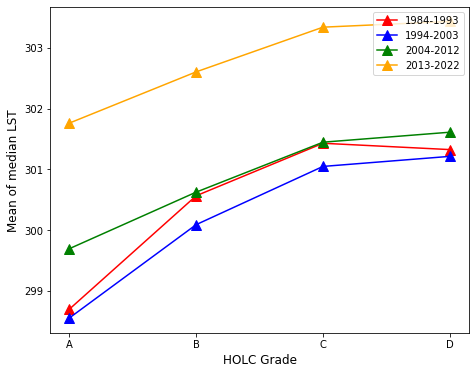

In [4]:
## USER INPUTS #####################################################################
column_choice = "median" # OPTIONS: median, mean, min, max, std
## END USER INPUTS #################################################################

plt.rcParams["figure.figsize"] = (7.5,6)

df_decade1 = df_stats[
    (df_stats["datetime"] >= datetime_year(1984)) & \
    (df_stats["datetime"] < datetime_year(1994))]
df_decade2 = df_stats[
    (df_stats["datetime"] >= datetime_year(1994)) & \
    (df_stats["datetime"] < datetime_year(2004))]
df_decade3 = df_stats[
    (df_stats["datetime"] >= datetime_year(2004)) & \
    (df_stats["datetime"] < datetime_year(2013))]
df_decade4 = df_stats[
    (df_stats["datetime"] >= datetime_year(2013)) & \
    (df_stats["datetime"] <= datetime_year(2022))]

font_size = 12
HOLC_grade = ["A", "B", "C", "D"]

plt.plot(HOLC_grade, df_decade1.groupby("holc_grade").mean()[column_choice],
           marker="^", markersize=10, c="r", label="1984-1993")
plt.plot(HOLC_grade, df_decade2.groupby("holc_grade").mean()[column_choice],
           marker="^", markersize=10, c="b", label="1994-2003")
plt.plot(HOLC_grade, df_decade3.groupby("holc_grade").mean()[column_choice],
           marker="^", markersize=10, c="g", label="2004-2012")
plt.plot(HOLC_grade, df_decade4.groupby("holc_grade").mean()[column_choice],
           marker="^", markersize=10, c="orange", label="2013-2022")
plt.legend(loc="upper right")


plt.xlabel("HOLC Grade", fontsize=font_size)
plt.ylabel("Mean of " + column_choice + " "+lbls_plot[obs_choice], fontsize=font_size)

plt.savefig(DIR_FIGS + "/"+column_choice+"-"+prefix_fname[obs_choice]+
            "-vs-HOLC_decades"+"_filt"+str(pixelfrac_filter)+".png")

### E. Plot the absolute difference from HOLC A

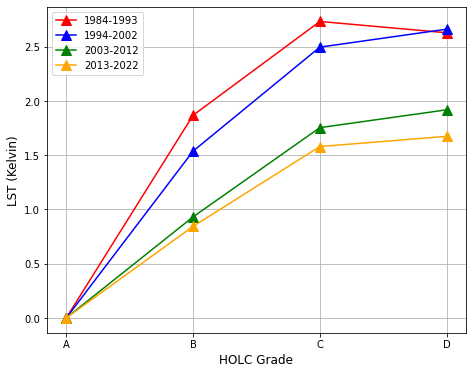

In [5]:
## USER INPUTS #####################################################################
column_choice = "median" # OPTIONS: median, mean, min, max, std
## END USER INPUTS #################################################################

plt.rcParams["figure.figsize"] = (7.5,6)

df_decade1 = df_stats[(df_stats["datetime"] >= datetime_year(1984)) & \
          (df_stats["datetime"] < datetime_year(1994))]
df_decade2 = df_stats[(df_stats["datetime"] >= datetime_year(1994)) & \
          (df_stats["datetime"] < datetime_year(2004))]
df_decade3 = df_stats[(df_stats["datetime"] >= datetime_year(2004)) & \
          (df_stats["datetime"] < datetime_year(2013))]
df_decade4 = df_stats[(df_stats["datetime"] >= datetime_year(2013)) & \
          (df_stats["datetime"] <= datetime_year(2022))]

font_size = 12
HOLC_grade = ["A", "B", "C", "D"]

decade1_Amean = df_decade1.groupby("holc_grade").mean()[column_choice][0]
plt.plot(HOLC_grade, 
    abs(df_decade1.groupby("holc_grade").mean()[column_choice]-
    decade1_Amean),marker="^", markersize=10, c="r", label="1984-1993")

decade2_Amean = df_decade2.groupby("holc_grade").mean()[column_choice][0]
plt.plot(HOLC_grade, 
    abs(df_decade2.groupby("holc_grade").mean()[column_choice]-
    decade2_Amean),marker="^", markersize=10, c="b", label="1994-2002")

decade3_Amean = df_decade3.groupby("holc_grade").mean()[column_choice][0]
plt.plot(HOLC_grade, abs(
    df_decade3.groupby("holc_grade").mean()[column_choice]-decade3_Amean),
           marker="^", markersize=10, c="g", label="2003-2012")

decade4_Amean = df_decade4.groupby("holc_grade").mean()[column_choice][0]
plt.plot(HOLC_grade, abs(
    df_decade4.groupby("holc_grade").mean()[column_choice]-decade4_Amean),
           marker="^", markersize=10, c="orange", label="2013-2022")

plt.legend(loc="upper left")
plt.grid()
    
# plt.title(obs_label + " - "+ obs_label + "(HOLC_A)")
plt.xlabel("HOLC Grade", fontsize=font_size)
plt.ylabel(lbls_y[obs_choice], fontsize=font_size)

plt.savefig(DIR_FIGS + "/"+column_choice+"-"+prefix_fname[obs_choice]+
            "-vs-HOLC_decades-difference"+"_filt"+\
            str(pixelfrac_filter)+".png")

## 2. Plot Data Using Aggregated Data from Method 2

Import data in the first cell to be used in the rest of the document. 

In [3]:
## USER INPUTS #####################################################################
yr = 0 # OPTIONS: 0 to 3
pixelfrac_filter = 0.0 # OPTIONS: 0.0, or 0.9
obs_choice = 0 # OPTIONS: 1=LST, 2=NDVI
## END USER INPUTS #################################################################

importname = DIR_STATS_T + "/m2_ext_"+prefix_fname[obs_choice]+"_yr"+str(yr)+"_"+\
            "pfilt"+str(pixelfrac_filter)+".csv"
df_mean_stats = pd.read_csv(importname)
df_mean_stats = df_mean_stats[df_mean_stats["holc_grade"]!="E"]

### A. Box-and-whisker plot in NYC by decade <a id="agg-box-whisker-temp"></a>

Text(0.5, 1.0, 'LST 1984-1993')

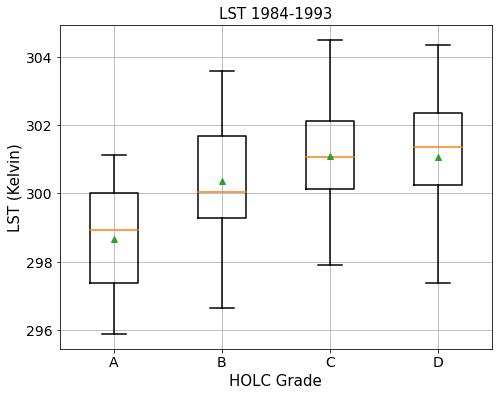

In [5]:
## USER INPUTS #####################################################################
font_size = 15
column_choice = "median" # OPTIONS: median, mean, min, max, std
## END USER INPUTS #################################################################

ax = df_mean_stats.boxplot(
                column=[column_choice], 
                by=["holc_grade"],
                grid=False,
                showmeans=True,
                showfliers=False,
                color=dict(boxes='r', whiskers='r', medians='r', 
                           caps='r'),
                boxprops=dict(linestyle='-', linewidth=1.5),
                flierprops=dict(linestyle='-', linewidth=1.5),
                medianprops=dict(linestyle='-', linewidth=1.5),
                whiskerprops=dict(linestyle='-', linewidth=1.5),
                capprops=dict(linestyle='-', linewidth=1.5),
                fontsize=font_size-1)

plt.grid()
ax.set_xlabel("HOLC Grade", fontsize=font_size)
ax.set_ylabel(lbls_y[obs_choice], fontsize=font_size)
fig = ax.get_figure()
fig.suptitle("") # Remove default Pandas title
plt.title(lbls_plot[obs_choice]+" "+lbls_yr[yr], fontsize=font_size)
# plt.savefig(DIR_FIGS + "/boxplot_nyc_"+column_choice+"_lst"+"_filt"+\
#             str(pixelfrac_filter)+".png",
#             bbox_inches="tight")

### B. Average median observable plotted for all decades <a id="agg-decade-temp"></a>

Text(0, 0.5, 'Mean of MedianLST (Kelvin)')

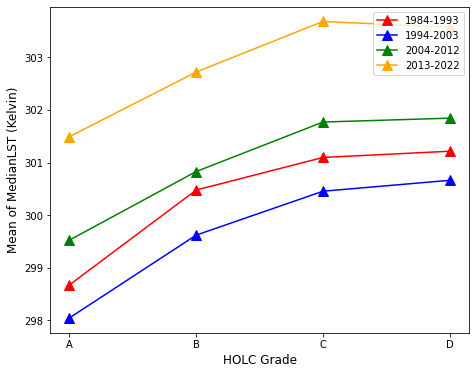

In [9]:
## USER INPUTS #####################################################################
pixelfrac_filter = 0.9 # OPTIONS: 0.0 or 0.9
obs_choice = 0 # OPTIONS: 0 for LST and 1 for NDVI
column_choice = "median" # OPTIONS: median, mean, min, max, std
## END USER INPUTS #################################################################

plt.rcParams["figure.figsize"] = (7.5,6)

df_mean_stats0 = pd.read_csv(DIR_STATS_T + "/m2_ext_"+prefix_fname[obs_choice]+"_yr0_"+"pfilt"+str(pixelfrac_filter)+".csv")
df_mean_stats1 = pd.read_csv(DIR_STATS_T + "/m2_ext_"+prefix_fname[obs_choice]+"_yr1_"+"pfilt"+str(pixelfrac_filter)+".csv")
df_mean_stats2 = pd.read_csv(DIR_STATS_T + "/m2_ext_"+prefix_fname[obs_choice]+"_yr2_"+"pfilt"+str(pixelfrac_filter)+".csv")
df_mean_stats3 = pd.read_csv(DIR_STATS_T + "/m2_ext_"+prefix_fname[obs_choice]+"_yr3_"+"pfilt"+str(pixelfrac_filter)+".csv")

font_size = 12
HOLC_grade = ["A", "B", "C", "D"]

plt.plot(HOLC_grade, df_mean_stats0.groupby("holc_grade").mean()[column_choice][:-1],
           marker="^", markersize=10, c="r", label="1984-1993")
plt.plot(HOLC_grade, df_mean_stats1.groupby("holc_grade").mean()[column_choice][:-1],
           marker="^", markersize=10, c="b", label="1994-2003")
plt.plot(HOLC_grade, df_mean_stats2.groupby("holc_grade").mean()[column_choice][:-1],
           marker="^", markersize=10, c="g", label="2004-2012")
plt.plot(HOLC_grade, df_mean_stats3.groupby("holc_grade").mean()[column_choice][:-1],
           marker="^", markersize=10, c="orange", label="2013-2022")

plt.legend(loc="upper right")
plt.xlabel("HOLC Grade", fontsize=font_size)
plt.ylabel("Mean of Median" + lbls_y[obs_choice], fontsize=font_size)

# plt.savefig(DIR_FIGS + "/"+column_choice+"-"+obs_label+
#             "-vs-HOLC_decades.png")

### C. Plot the difference from the HOLC A value

Text(0, 0.5, 'Mean of median LST (Kelvin)')

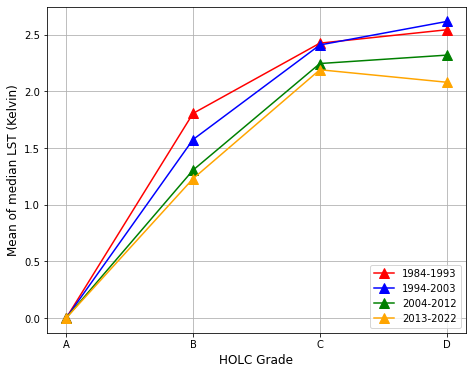

In [42]:
## USER INPUTS #####################################################################
pixelfrac_filter = 0.9 # OPTIONS: 0.0, 0.8, or 0.9
obs_choice = 0 # OPTIONS: 0 for LST and 1 for NDVI
column_choice = "median" # OPTIONS: median, mean, min, max, std
## END USER INPUTS #################################################################


plt.rcParams["figure.figsize"] = (7.5,6)
df_mean_stats0 = pd.read_csv(DIR_STATS_T + "/m2_ext_"+prefix_fname[obs_choice]+"_yr0_"+"pfilt"+str(pixelfrac_filter)+".csv")
df_mean_stats1 = pd.read_csv(DIR_STATS_T + "/m2_ext_"+prefix_fname[obs_choice]+"_yr1_"+"pfilt"+str(pixelfrac_filter)+".csv")
df_mean_stats2 = pd.read_csv(DIR_STATS_T + "/m2_ext_"+prefix_fname[obs_choice]+"_yr2_"+"pfilt"+str(pixelfrac_filter)+".csv")
df_mean_stats3 = pd.read_csv(DIR_STATS_T + "/m2_ext_"+prefix_fname[obs_choice]+"_yr3_"+"pfilt"+str(pixelfrac_filter)+".csv")

font_size = 12
HOLC_grade = ["A", "B", "C", "D"]

decade0_Amean = df_mean_stats0.groupby("holc_grade").mean()[column_choice][0]
plt.plot(HOLC_grade, abs(df_mean_stats0.groupby("holc_grade").mean()[column_choice][:-1]-decade0_Amean),
           marker="^", markersize=10, c="r", label="1984-1993")
decade1_Amean = df_mean_stats1.groupby("holc_grade").mean()[column_choice][0]
plt.plot(HOLC_grade, abs(df_mean_stats1.groupby("holc_grade").mean()[column_choice][:-1]-decade1_Amean),
           marker="^", markersize=10, c="b", label="1994-2003")
decade2_Amean = df_mean_stats2.groupby("holc_grade").mean()[column_choice][0]
plt.plot(HOLC_grade, abs(df_mean_stats2.groupby("holc_grade").mean()[column_choice][:-1]-decade2_Amean),
           marker="^", markersize=10, c="g", label="2004-2012")
decade3_Amean = df_mean_stats3.groupby("holc_grade").mean()[column_choice][0]
plt.plot(HOLC_grade, abs(df_mean_stats3.groupby("holc_grade").mean()[column_choice][:-1]-decade3_Amean),
           marker="^", markersize=10, c="orange", label="2013-2022")
plt.grid()
plt.legend(loc="lower right")
plt.xlabel("HOLC Grade", fontsize=font_size)
plt.ylabel("Mean of median "+lbls_y[obs_choice], fontsize=font_size)

# plt.savefig(DIR_FIGS + "/"+column_choice+"-"+prefix_fname[obs_choice]+
#             "-vs-HOLC_decades"+"_filt"+\
#             str(pixelfrac_filter)+".png")

## 2. Plot Data Using Aggregated Data from Method 3

### A. Plot the LST/NDVI over the Whole Decade

Text(0, 0.5, 'Mean of MedianLST (Kelvin)')

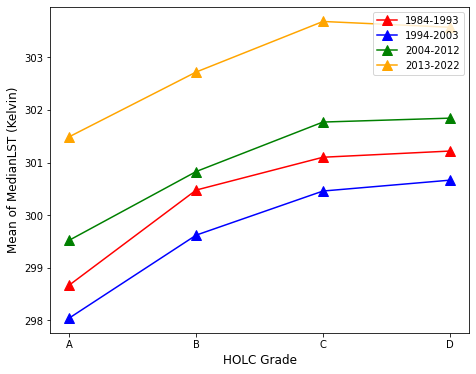

In [14]:
## USER INPUTS #####################################################################
pixelfrac_filter = 0.9 # OPTIONS: 0.0, or 0.9
obs_choice = 0 # OPTIONS: 0 for LST and 1 for NDVI
column_choice = "median" # OPTIONS: median, mean, min, max, std
## END USER INPUTS #################################################################

df_mean_stats0 = pd.read_csv(DIR_STATS_T + "/m3_ext_"+prefix_fname[obs_choice]+\
                "_pfilt"+str(pixelfrac_filter)+"_yr0.csv")
df_mean_stats1 = pd.read_csv(DIR_STATS_T + "/m3_ext_"+prefix_fname[obs_choice]+\
                "_pfilt"+str(pixelfrac_filter)+"_yr1.csv")
df_mean_stats2 = pd.read_csv(DIR_STATS_T + "/m3_ext_"+prefix_fname[obs_choice]+\
                "_pfilt"+str(pixelfrac_filter)+"_yr2.csv")
df_mean_stats3 = pd.read_csv(DIR_STATS_T + "/m3_ext_"+prefix_fname[obs_choice]+\
                "_pfilt"+str(pixelfrac_filter)+"_yr3.csv")

font_size = 12
HOLC_grade = ["A", "B", "C", "D"]

plt.plot(HOLC_grade, df_mean_stats0[column_choice][:-1],
           marker="^", markersize=10, c="r", label=lbls_yr[0])
plt.plot(HOLC_grade, df_mean_stats1[column_choice][:-1],
           marker="^", markersize=10, c="b", label="1994-2003")
plt.plot(HOLC_grade, df_mean_stats2[column_choice][:-1],
           marker="^", markersize=10, c="g", label="2004-2012")
plt.plot(HOLC_grade, df_mean_stats3[column_choice][:-1],
           marker="^", markersize=10, c="orange", label="2013-2022")

plt.legend(loc="upper right")
plt.xlabel("HOLC Grade", fontsize=font_size)
plt.ylabel("Mean of Median" + lbls_y[obs_choice], fontsize=font_size)

### B. Plot the difference from HOLC A

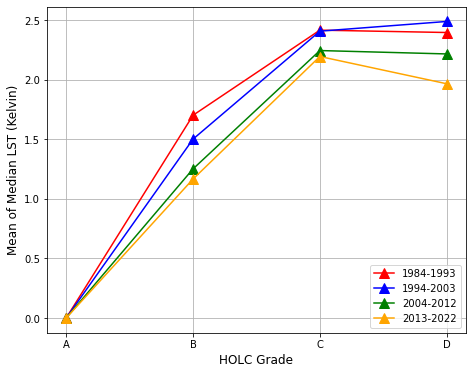

In [40]:
## USER INPUTS #####################################################################
pixelfrac_filter = 0.0 # OPTIONS: 0.0, 0.8, or 0.9
obs_choice = 0 # OPTIONS: 0 for LST and 1 for NDVI
column_choice = "median" # OPTIONS: median, mean, min, max, std
## END USER INPUTS #################################################################

df_mean_stats0 = pd.read_csv(DIR_STATS_T + "/m3_ext_"+prefix_fname[obs_choice]+\
                "_pfilt"+str(pixelfrac_filter)+"_yr0.csv")
df_mean_stats1 = pd.read_csv(DIR_STATS_T + "/m3_ext_"+prefix_fname[obs_choice]+\
                "_pfilt"+str(pixelfrac_filter)+"_yr1.csv")
df_mean_stats2 = pd.read_csv(DIR_STATS_T + "/m3_ext_"+prefix_fname[obs_choice]+\
                "_pfilt"+str(pixelfrac_filter)+"_yr2.csv")
df_mean_stats3 = pd.read_csv(DIR_STATS_T + "/m3_ext_"+prefix_fname[obs_choice]+\
                "_pfilt"+str(pixelfrac_filter)+"_yr3.csv")

decade0a = df_mean_stats0[df_mean_stats0["holc_grade"]=="A"][column_choice].loc[0]
decade1a = df_mean_stats1[df_mean_stats1["holc_grade"]=="A"][column_choice].loc[0]
decade2a = df_mean_stats2[df_mean_stats2["holc_grade"]=="A"][column_choice].loc[0]
decade3a = df_mean_stats3[df_mean_stats3["holc_grade"]=="A"][column_choice].loc[0]

font_size = 12
HOLC_grade = ["A", "B", "C", "D"]

plt.plot(HOLC_grade, abs(df_mean_stats0[column_choice][:-1]-decade0a),
           marker="^", markersize=10, c="r", label=lbls_yr[0])
plt.plot(HOLC_grade, abs(df_mean_stats1[column_choice][:-1]-decade1a),
           marker="^", markersize=10, c="b", label="1994-2003")
plt.plot(HOLC_grade, abs(df_mean_stats2[column_choice][:-1]-decade2a),
           marker="^", markersize=10, c="g", label="2004-2012")
plt.plot(HOLC_grade, abs(df_mean_stats3[column_choice][:-1]-decade3a),
           marker="^", markersize=10, c="orange", label="2013-2022")

plt.grid()

plt.legend(loc="lower right")
plt.xlabel("HOLC Grade", fontsize=font_size)
plt.ylabel("Mean of Median " + lbls_y[obs_choice], fontsize=font_size)

plt.savefig(DIR_FIGS + "/"+column_choice+"-"+prefix_fname[obs_choice]+
            "-vs-HOLC_decades"+"_filt"+\
            str(pixelfrac_filter)+"v2.png")

## 4. Plot Data Using Aggregated Data from Method 4

### A. For a single decade, plot LST/NDVI across HOLC Grades

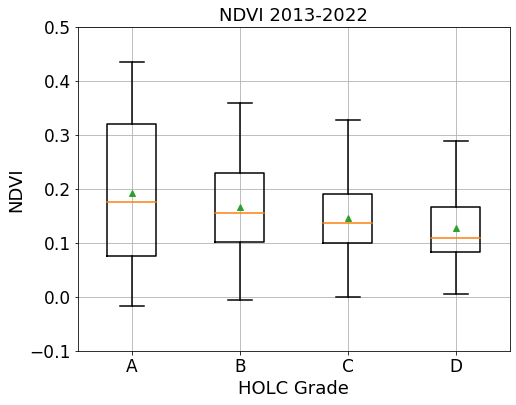

In [86]:
## USER INPUTS #####################################################################
yr = 3
pixelfrac_filter = 0.9 # OPTIONS: 0.0, or 0.9
obs_choice = 1 # OPTIONS: 0 for LST and 1 for NDVI
column_choice = "median" # OPTIONS: median, mean, min, max, std
## END USER INPUTS #################################################################

df_mean_stats = pd.read_csv(DIR_STATS_T + "/m4_ext_"+prefix_fname[obs_choice]+\
                "_pfilt"+str(pixelfrac_filter)+"_yr"+str(yr)+".csv")
df_mean_stats = df_mean_stats[df_mean_stats["holc_grade"]!="E"]

font_size = 18
HOLC_grade = ["A", "B", "C", "D"]

ax = df_mean_stats.boxplot(
                column=[column_choice], 
                by=["holc_grade"],
                grid=False,
                showmeans=True,
                showfliers=False,
                color=dict(boxes='r', whiskers='r', medians='r', 
                           caps='r'),
                boxprops=dict(linestyle='-', linewidth=1.5),
                flierprops=dict(linestyle='-', linewidth=1.5),
                medianprops=dict(linestyle='-', linewidth=1.5),
                whiskerprops=dict(linestyle='-', linewidth=1.5),
                capprops=dict(linestyle='-', linewidth=1.5),
                fontsize=font_size-1)
if obs_choice==0:
    ax.set_ylim([285, 315])
else:
    ax.set_ylim([-0.1,0.5])

plt.grid()
plt.title
plt.xlabel("HOLC Grade", fontsize=font_size)
plt.ylabel(lbls_y[obs_choice], fontsize=font_size)

fig = ax.get_figure()
fig.suptitle("") # Remove default Pandas title
plt.title(lbls_plot[obs_choice]+" "+lbls_yr[yr], fontsize=font_size)

plt.savefig(DIR_FIGS + "/m4_boxplots_"+column_choice+"-"+prefix_fname[obs_choice]+\
            "_yr"+str(yr)+"_filt"+ str(pixelfrac_filter)+".png", bbox_inches = "tight")

### B. For a single HOLC grade, plot the LST/NDI over decades

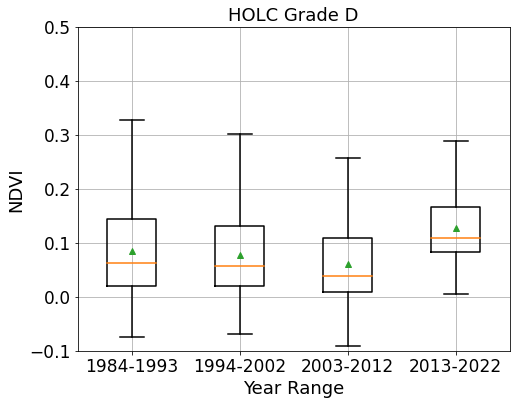

In [111]:
## USER INPUTS #####################################################################
pixelfrac_filter = 0.9 # OPTIONS: 0.0, or 0.9
grade_choice = "D"
obs_choice = 1 # OPTIONS: 0 for LST and 1 for NDVI
column_choice = "median" # OPTIONS: median, mean, min, max, std
## END USER INPUTS #################################################################

df_mean_stats0 = pd.read_csv(DIR_STATS_T + "/m4_ext_"+prefix_fname[obs_choice]+\
                "_pfilt"+str(pixelfrac_filter)+"_yr0.csv")
df_mean_stats1 = pd.read_csv(DIR_STATS_T + "/m4_ext_"+prefix_fname[obs_choice]+\
                "_pfilt"+str(pixelfrac_filter)+"_yr1.csv")
df_mean_stats2 = pd.read_csv(DIR_STATS_T + "/m4_ext_"+prefix_fname[obs_choice]+\
                "_pfilt"+str(pixelfrac_filter)+"_yr2.csv")
df_mean_stats3 = pd.read_csv(DIR_STATS_T + "/m4_ext_"+prefix_fname[obs_choice]+\
                "_pfilt"+str(pixelfrac_filter)+"_yr3.csv")

df_mean_stats = pd.concat([df_mean_stats0,df_mean_stats1,df_mean_stats2,df_mean_stats3])

df_mean_stats = df_mean_stats[df_mean_stats["holc_grade"]==grade_choice]

font_size = 18

ax = df_mean_stats.boxplot(
                column=[column_choice], 
                by=["year_range"],
                grid=False,
                showmeans=True,
                showfliers=False,
                color=dict(boxes='r', whiskers='r', medians='r', 
                           caps='r'),
                boxprops=dict(linestyle='-', linewidth=1.5),
                flierprops=dict(linestyle='-', linewidth=1.5),
                medianprops=dict(linestyle='-', linewidth=1.5),
                whiskerprops=dict(linestyle='-', linewidth=1.5),
                capprops=dict(linestyle='-', linewidth=1.5),
                fontsize=font_size-1)

if obs_choice==0:
    ax.set_ylim([285, 315])
else:
    ax.set_ylim([-0.1,0.5])

plt.grid()
plt.title
plt.xlabel("Year Range", fontsize=font_size)
plt.ylabel(lbls_y[obs_choice], fontsize=font_size)

fig = ax.get_figure()
fig.suptitle("") # Remove default Pandas title
plt.title("HOLC Grade "+grade_choice, fontsize=font_size)

plt.savefig(DIR_FIGS + "/m4_boxplots_"+column_choice+"-"+prefix_fname[obs_choice]+\
            "_grade"+grade_choice+"_filt"+ str(pixelfrac_filter)+".png", bbox_inches = "tight")

## 5. Plot Cloudy Boundary

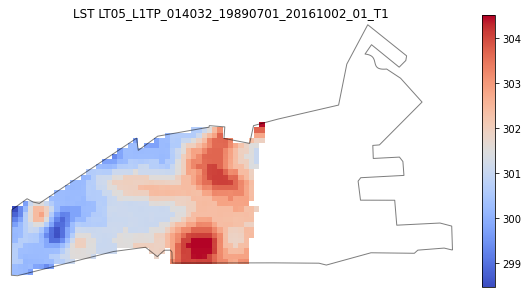

In [220]:
## USER INPUTS #####################################################################
obs_choice = 0 # OPTIONS: 0 for LST and 1 for NDVI
column_choice = "median" # OPTIONS: median, mean, min, max, std
## END USER INPUTS #################################################################

df_mean_stats = pd.read_csv(DIR_STATS_T + "/m4_ext_"+prefix_fname[obs_choice]+\
                "_pfilt0.0_yr"+str(yr)+".csv")

"""Find a boundary that has roughtly 50% cloud cover"""
df_mean_stats = df_mean_stats[(df_mean_stats["pixel_frac"]>0.4) & (df_mean_stats["pixel_frac"]<0.6)]
df_mean_stats.reset_index(inplace=True)

"""Get the CRS from landsat"""
crs_landsat = rxr.open_rasterio(DIR_LST_CLIPPED_NYC+"/"+prefix_fname[0] + "_" + \
                                df_mean_stats.loc[0]["landsat_id"]+".tif", 
                                masked=True).rio.crs

# """Import the Queens boundary since both partially covered HOLC boundaries occur there"""
df_holc = gpd.read_file(DIR_BOUNDARIES_HOLC+"/NYQueens1938/cartodb-query.shp")
df_holc = df_holc.to_crs(crs_landsat)

clipping_boundary = df_holc[df_holc["holc_id"]==df_mean_stats.loc[0]["holc_id"]]["geometry"]

if obs_choice==0:
    clipped = helpers.open_and_clip(DIR_LST_CLIPPED_NYC+"/"+prefix_fname[0] +\
                                "_" + df_mean_stats.loc[0]["landsat_id"]+".tif", 
                                clipping_boundary)
else:
    clipped = helpers.open_and_clip(DIR_NDVI_CLIPPED_NYC+"/"+prefix_fname[1] +\
                                "_" + df_mean_stats.loc[0]["landsat_id"]+".tif", 
                                clipping_boundary)

clipped_masked = clipped.where(clipped != -0.0) 
clipped_masked = clipped_masked.where(clipped_masked != -9999.0) 
    
"""Plot the boundary overlaid on the image"""
f, ax = plt.subplots(figsize=(10, 5))
if obs_choice==0:
    im = clipped_masked.plot.imshow(ax=ax, cmap="coolwarm")
    # clb = plt.colorbar(im)
    # clb.set_label("K", labelpad=-40, y=1.05, rotation=0)
else:
    clipped_masked.plot.imshow(ax=ax, cmap="YlGn")        
clipping_boundary.plot(ax=ax, alpha=.5,color="none", edgecolor="black")
ax.set(title=lbls_plot[obs_choice]+" "+df_mean_stats.loc[0]["landsat_id"])
ax.set_axis_off()

plt.savefig(DIR_FIGS + "/cloud-cover-example-holc-boundary.png", bbox_inches = "tight")

## 6. Plot Examples of LST/NDVI across NYC

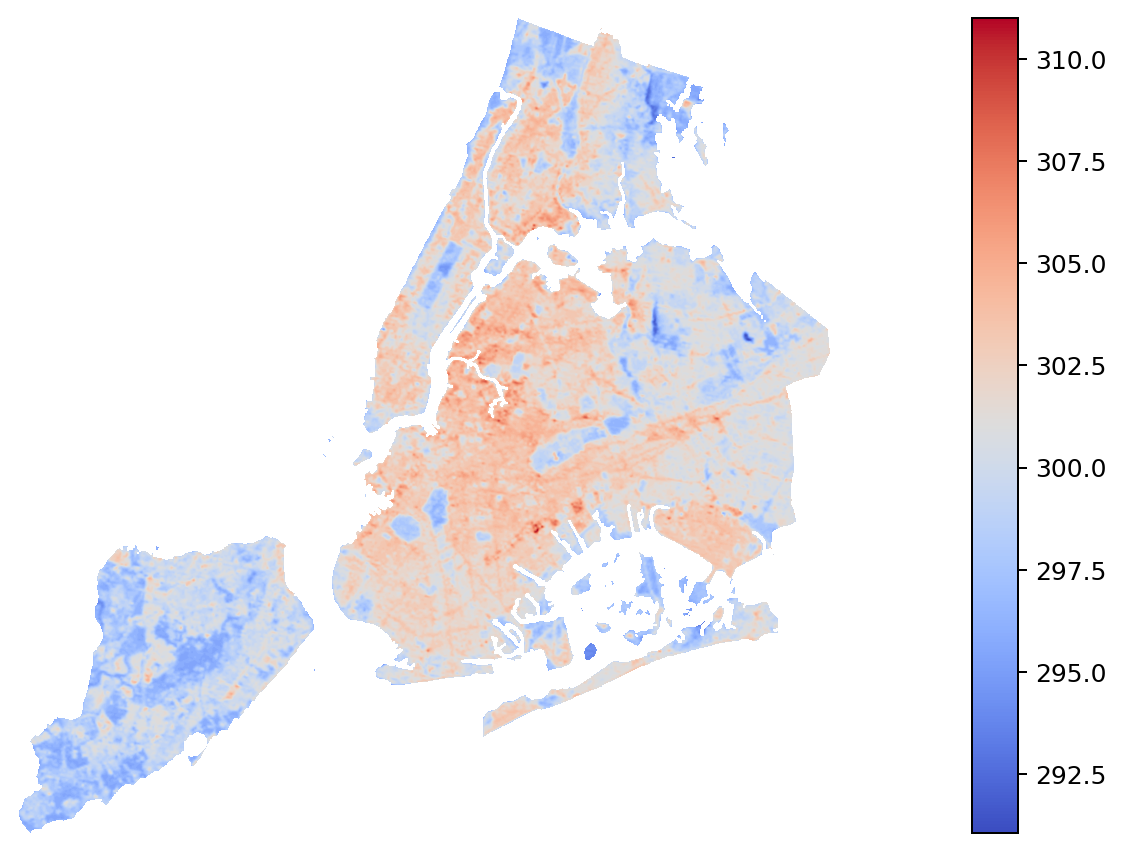

In [271]:
## USER INPUTS #####################################################################
obs_choice = 0 # OPTIONS: 0 for LST and 1 for NDVI
column_choice = "median" # OPTIONS: median, mean, min, max, std
## END USER INPUTS #################################################################

clipped_filenames = []
if obs_choice==0:
    helpers.get_filenames(DIR_LST_CLIPPED_NYC, clipped_filenames)
else:
    helpers.get_filenames(DIR_NDVI_CLIPPED_NYC, clipped_filenames)
clipped = rxr.open_rasterio(clipped_filenames[2], masked=True).squeeze()

clipped_masked = clipped.where(clipped_masked != -9999.0) 

import matplotlib.gridspec as gridspec

"""Plot the boundary overlaid on the image"""
gs = gridspec.GridSpec(1,2,width_ratios=[20,1])
fig = plt.figure(facecolor='w', dpi=180)
ax1 = fig.add_subplot(gs[0])
ax1.grid(False)
if obs_choice==0:
    amap = ax1.imshow(clipped_masked, cmap="coolwarm")
else:
    amap = ax1.imshow(clipped_masked)
fig.colorbar(amap, cax=fig.add_subplot(gs[1]))
ax1.set_axis_off()

plt.savefig(DIR_FIGS +"/example_"+prefix_fname[obs_choice]+".png", bbox_inches="tight")
